In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

#### Загрузка данных

In [2]:
train_data = pd.read_csv('data_toxic/toxic_train.csv', index_col=0)
test_data = pd.read_csv('data_toxic/toxic_test.csv', index_col=0)

Text(0.5, 1, 'Распределение классов в трейне')

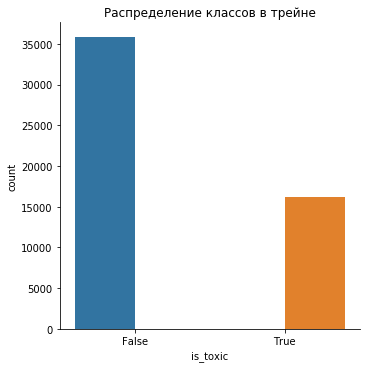

In [3]:
sns.catplot(x='is_toxic', data=train_data, hue='is_toxic', kind='count')
plt.title('Распределение классов в трейне')

In [4]:
target_train = train_data['is_toxic'].map({True : 1, False : -1})
train_data.drop(columns='is_toxic', inplace=True)

### 1. Приводим к нижнему регистру и заменяем все символы, не являющиеся буквами или цифрами на пробелы

In [5]:
train_data_processed_1 = train_data.copy()
test_data_processed_1 = test_data.copy()

In [6]:
import re

def text_process_1(texts_series):
    """
    Takes series with texts
    returns series with preprocessed texts
    (lower register + changed all symbols, which are not letter, number to spaces)
    """
    
    texts_series = texts_series.str.lower()
    texts_series = texts_series.apply(lambda x: re.sub(r'\W', ' ', x))
    return texts_series

In [7]:
train_data_processed_1 = text_process_1(train_data_processed_1['comment_text'])
test_data_processed_1 = text_process_1(test_data_processed_1['comment_text'])

### 2. Пользуемся CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
countVect = CountVectorizer(min_df=3e-5)

In [9]:
train_data_processed_2 = countVect.fit_transform(train_data_processed_1)
test_data_processed_2 = countVect.transform(test_data_processed_1)

In [10]:
train_data_processed_2.shape[1]

37832

In [11]:
import optimization
import scipy

Add bias

In [12]:
bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_2_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_2])
test_data_processed_2_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_2])

In [13]:
%%time
def experiment_cycle(train_data, target,
                     step_alpha_list, step_beta_list,
                     w_0_list, batch_size_list, l2_coef=5e-4):
    for step_alpha in step_alpha_list:
        for step_beta in step_beta_list:
            for w_0 in w_0_list:
#                 print(step_alpha)
                clf = optimization.GDClassifier(step_alpha=step_alpha,
                                                step_beta=step_beta,
                                                experiment=True,
                                                l2_coef=l2_coef,
                                                max_iter=5000)
                yield clf.fit(train_data,
                                target,
                                w_0=w_0,
                                trace=True)
                
    for step_alpha in step_alpha_list:
        for step_beta in step_beta_list:
            for w_0 in w_0_list:
                for batch_size in batch_size_list:
                    clf = optimization.SGDClassifier(step_alpha=step_alpha,
                                                     step_beta=step_beta,
                                                     experiment=True,
                                                     max_iter=5000,
                                                     batch_size=batch_size, 
                                                     l2_coef=l2_coef)
                    yield clf.fit(train_data,
                                  target,
                                  w_0=w_0,
                                  trace=True, log_freq=0.1)
                    


CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 3.81 µs


In [14]:
train_data_processed_2.shape

(52061, 37832)

## ВАЖНО! Все эксперименты будут проводиться с добавлением смещения в веса, которое не будет учитываться в регуляризации (чтобы даже в том случае, когда регуляризация занулит почти все веса, наша разделяющая гиперплоскость не вырождалась в 0)

In [ ]:
import tqdm
history_list = []
step_alpha_list = [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 25]
# step_alpha_list = [0.1]
step_beta_list = [0, 0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 25]
batch_size_list = [1, 128, 256, 512, 1024, 1024 * 4, 1024 * 10, 1024 * 20]
w_0_list = [None]
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_2_with_bias, target_train.values,
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

In [ ]:
keys_for_df = ['time', 'func', 'accuracy']

In [ ]:
len(history_list[0]['time']), len(history_list[0]['func']), len(history_list[0]['accuracy']),

In [ ]:
history_list[50]['classifier_type'], history_list[30]['step_alpha']

In [ ]:
hist_0_df = pd.DataFrame({key: history_list[29][key] for key in keys_for_df})
hist_1_df = pd.DataFrame({key: history_list[300][key] for key in keys_for_df})

In [ ]:
sns.lineplot(x = np.cumsum(np.arange(len(hist_0_df['accuracy']))), y=hist_0_df['accuracy'])
sns.lineplot(x = np.cumsum(np.arange(len(hist_1_df['accuracy']))), y=hist_1_df['accuracy'])
# plt.semilogy()

In [ ]:
import pickle
with open('GD_SGD_step_alpha_beta_batch_size.pkl', 'wb') as f:
    pickle.dump(history_list, f)

## Эксперименты с различными начальными приближениями:
https://datascience.stackexchange.com/questions/30989/what-are-the-cases-where-it-is-fine-to-initialize-all-weights-to-zero
###   Рассмотрим 7 экспериментов: 
    1) w_0 = 0
    2) w_0 = uniform(0, 1)
    3) w_0 = uniform(100, 500)
    4) w_0 = uniform(1000, 5000)
    5) w_0 = uniform (10000, 50000)
    6) w_0 = normal with mean = 0, std = 1
    7) w_0 = normal with mean = 0.5, std = 0.5

In [ ]:
w_0_list = []
w_0_list.append(np.zeros(train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(0, 1, size=train_data_processed_2_with_bias.shape[1]))

w_0_list.append(np.random.uniform(100, 500, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(1000, 5000, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(10000, 50000, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.normal(0, 1, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_2_with_bias.shape[1]))

In [ ]:
train_data_processed_2_with_bias.shape

In [ ]:
w_0_list[0].shape

###  Выберем лучшие параметры из прошлого эксперимента:

In [ ]:
import pickle 
history_list = []
with open('GD_SGD_step_alpha_beta_batch_size.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [ ]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [ ]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[1])

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1])

In [ ]:
import tqdm
step_alpha_list = [history_list[arg_max[0]]['step_alpha']]
step_beta_list = [history_list[arg_max[0]]['step_beta']]
batch_size_list = [history_list[arg_max[1]]['batch_size']]
history_list = []
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_2_with_bias, target_train.values,
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

In [ ]:
max(history_list[0]['accuracy']), max(history_list[-1]['accuracy'])

In [ ]:
import pickle
with open('GD_SGD_w_0_init.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [ ]:
with open('GD_SGD_w_0_init.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [ ]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [ ]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1],
      arg_max[1] - 6)

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
lemmatizer = nltk.WordNetLemmatizer() 

In [ ]:
train_data_processed_1

In [ ]:
%%time
train_data_processed_lemmatized = train_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem) for elem in x])
test_data_processed_lemmatized = test_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem) for elem in x])

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

In [ ]:
%%time
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
train_data_processed_3 = train_data_processed_3.apply(lambda x: ' '.join(x))

test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
test_data_processed_3 = test_data_processed_3.apply(lambda x: ' '.join(x))

In [ ]:
%%time
train_data_processed_3 = countVect.fit_transform(train_data_processed_3)
test_data_processed_3 = countVect.transform(test_data_processed_3)

Add bias

In [ ]:
bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3])
test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3])

## Так как лучшими значениями для w_0 оказались:
    1) GD - w_0 = zeros
    2) SGD - w_0 = normal with mean = 0.5, std = 0.5, поэтому:

In [ ]:
import tqdm
step_alpha_list = [history_list[arg_max[0]]['step_alpha']]
step_beta_list = [history_list[arg_max[0]]['step_beta']]
batch_size_list = [history_list[arg_max[1]]['batch_size']]
w_0_list = []
w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_3_with_bias.shape[1]))

# w_0_list.append(np.random.uniform(100, 500, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.uniform(1000, 5000, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.uniform(10000, 50000, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.normal(0, 1, size=train_data_processed_2_with_bias.shape[1]))
# w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_2_with_bias.shape[1]))
history_list = []
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

In [ ]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [ ]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1],
      arg_max[1] - 1)

In [ ]:
import pickle
with open('GD_SGD_lemmatized.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [ ]:
import pickle
with open('GD_SGD_lemmatized.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [ ]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [ ]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      max_acc[1],
      arg_max[1] - 1)

## Эксперименты с min_df и max_df
Если мы рассматриваем 0 <= min_df <= 1; 0 <= max_df <= 1, то они связаны формулой: $min\_df + max\_df = 1$, поэтому будем исследовать значение параметра $min\_df$

In [ ]:
%%time
import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
min_df_list = [1e-5, 2.5e-5, 5e-5, 7.5e-5,
               1e-4, 2.5e-4, 5e-4, 7.5e-4,
               1e-3, 2.5e-3, 5e-3, 7.5e-3]
preprocesser_type_list = ['BOW', 'TFIDF']

preprocesser = None

step_alpha_list = [history_list[arg_max[0]]['step_alpha']]
step_beta_list = [history_list[arg_max[0]]['step_beta']]
batch_size_list = [history_list[arg_max[1]]['batch_size']]
history_list = []


for min_df in min_df_list:
    for preprocesser_type in preprocesser_type_list:
        train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
        train_data_processed_3 = train_data_processed_3.apply(lambda x: ' '.join(x))

    #     test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
    #     test_data_processed_3 = test_data_processed_3.apply(lambda x: ' '.join(x))

        if preprocesser_type == 'BOW':
            preprocesser = CountVectorizer(min_df=min_df, lowercase=False)
        else:
            preprocesser = TfidfVectorizer(min_df=min_df, lowercase=False)

        train_data_processed_3 = preprocesser.fit_transform(train_data_processed_3)
    #     test_data_processed_3 = preprocesser.transform(test_data_processed_3)

        bias_feature_train = np.ones(train_data.shape[0])
    #     bias_feature_test = np.ones(test_data.shape[0])
        bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
    #     bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
        train_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_3])
    #     test_data_processed_3_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_3])
        w_0_list = []
        w_0_list.append(np.zeros(train_data_processed_3_with_bias.shape[1]))
        w_0_list.append(np.random.normal(0.5, 0.5, size=train_data_processed_3_with_bias.shape[1]))

        for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_3_with_bias, target_train.values,
                                    step_alpha_list,
                                    step_beta_list,
                                    w_0_list=w_0_list,
                                    batch_size_list=batch_size_list)):
            
            history['preprocesser_type'] = preprocesser_type
            history['min_df'] = min_df
            history_list.append(history)
    
    

In [ ]:
import pickle
with open('GD_SGD_bow_tfid_min_df.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [ ]:
import pickle
with open('GD_SGD_bow_tfid_min_df.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [ ]:
max_acc = [0, 0]
arg_max = [0, 0]
for i, history in enumerate(history_list):
    if history['classifier_type'] == 'GD':
        if np.max(history['accuracy']) > max_acc[0]:
            max_acc[0] = np.max(history['accuracy'])
            arg_max[0] = i
    else:
        if np.max(history['accuracy']) > max_acc[1]:
            max_acc[1] = np.max(history['accuracy'])
            arg_max[1] = i
    

In [ ]:
print(history_list[arg_max[0]]['step_alpha'],
      history_list[arg_max[0]]['step_beta'],
      history_list[arg_max[0]]['classifier_type'],
      history_list[arg_max[0]]['min_df'],
      history_list[arg_max[0]]['preprocesser_type'],
      max_acc[0],
      arg_max[0] + 1)

print(history_list[arg_max[1]]['step_alpha'],
      history_list[arg_max[1]]['step_beta'],
      history_list[arg_max[1]]['classifier_type'],
      history_list[arg_max[1]]['min_df'],
      history_list[arg_max[1]]['preprocesser_type'],
      max_acc[1],
      arg_max[1] - 1)

Add bias